In [44]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
matplotlib.rc('font', size=20)
matplotlib.rc('axes', titlesize=20)
matplotlib.rc('axes', labelsize=20)
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('legend', fontsize=20)
matplotlib.rc('figure', titlesize=20)

In [45]:
data = pd.read_csv("/Users/sominwadhwa/Work/Kaggle_Data/Quora/train.csv")
data.ix[np.random.choice(data.index, 10)]

,id,qid1,qid2,question1,question2,is_duplicate
28733,28733,53251,53252,Why do I feel like killing myself?,Why do I sometimes feel like killing myself bu...,0
14658,14658,28061,28062,Which is a good inpatient drug and alcohol reh...,Which is a good inpatient drug and alcohol reh...,0
306964,306964,430581,430582,How can I increase my aptitude skills?,How do i increase my aptitude level?,1
252553,252553,356634,21002,What type of government does Turkey have? How ...,What type of government does Turkey have? How ...,0
350237,350237,41877,478961,Why are iPhones costly?,What is it like to work in psiog/cyence startup?,0
222861,222861,330539,330540,What is the thing (see pic) in this tire air p...,"What is the best air pressure for a bicycle, b...",0
34784,34784,9571,63680,How can I know if someone blocked me from thei...,How can I tell if someone has blocked my messa...,0
190283,190283,75893,289307,What's the best way to get followers on insta?,What's the fastest way to build Instagram foll...,1
157121,157121,245753,245754,How credible is WikiLeaks?,Is WikiLeaks trustworthy?,0
107124,107124,176307,176308,What if I use red bull instead of water to mak...,Why does red bull give you wings?,0


In [46]:
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


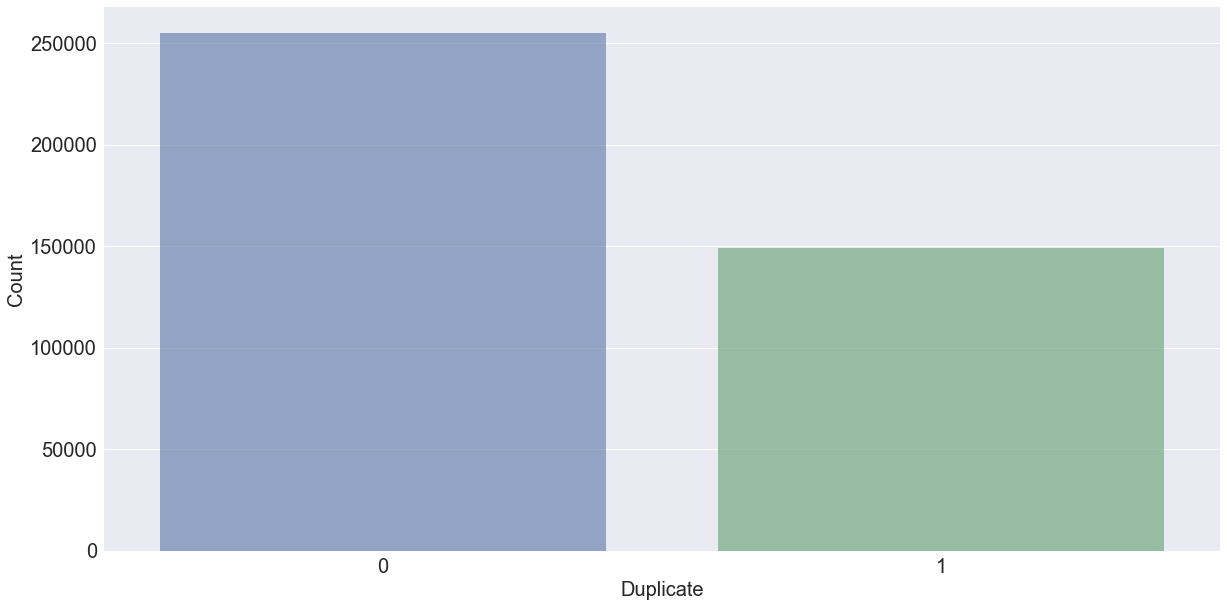

In [47]:
plt.figure(figsize=(20,10))
data_by_count = data.groupby('is_duplicate', as_index=False).id.count()
sns.barplot(data=data_by_count, x='is_duplicate', y='id', alpha=0.6)
plt.xlabel("Duplicate")
plt.ylabel("Count")

In [48]:
from collections import Counter
import operator
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import multiprocessing
import difflib
from sklearn.cross_validation import train_test_split
import xgboost as xgb

### Approach
0. Do simple Cosine/Jaccard similarity check w/o any semantic analysis whatsoever
1. Check for similarities in Test/Training Data
2. Create a list of all questions under one list
3. Do EDA - Word/Char Count Hist (labelling-dup or not), correlation, semantic analysis
4. Improvise with TF-IDF
5. Test different predictive models- Logistic, XGB etc with supporting ROC/P-R curves

In [49]:
stop = stopwords.words('english')

In [8]:
data = data.dropna()
data['question1'] = data['question1'].apply(lambda x: x.rstrip('?'))
data['question2'] = data['question2'].apply(lambda x: x.rstrip('?'))
data['question1'] = data['question1'].str.lower().str.split()
data['question2'] = data['question2'].str.lower().str.split()
data['question1'] = data['question1'].apply(lambda x: [item for item in x if item not in stop])
data['question2'] = data['question2'].apply(lambda x: [item for item in x if item not in stop])

In [9]:
data.ix[np.random.choice(data.index, 10)]

,id,qid1,qid2,question1,question2,is_duplicate
106220,106220,175018,175019,"[explored, world, completely]","[need, world]",0
198212,198212,299363,299364,"[anyone, list, best, motivational, quotes, mov...","[learn, people, facebook, posts]",0
239331,239331,350897,350898,"[franz, kafka, son]","[like, franz, kafka's, works]",0
265619,265619,94449,8102,"[lose, fat, without, aerobic, physical, activity]","[lose, weight, month, without, exercise]",1
108049,108049,177611,177612,"[daughter, wants, marry, person, doesn't, job,...","[realized, 23-year-old, fiancée,, comes, reser...",0
231434,231434,341236,301451,"[change, earrings, 2, weeks, piercing]","[got, ears, pierced, 6, gauge, weeks, ago, kee...",0
209291,209291,313536,313537,"[room, look, like]","[room, look, like, programmer]",0
213232,213232,4369,99419,"[isolating, pakistan, international, stage, be...","[india’s, best, reply, pakistan, uri, attack]",1
86619,86619,146059,62261,"[reaction, india, recent, uri, attack]","[india, respond, uri, attacks]",0
297044,297044,317167,419363,"[best, way, learn, make, edm, (electronic, dan...","[what's, best, music, producing, software, edm]",0


In [10]:
data['Common'] = data.apply(lambda row: len(list(set(row['question1']).intersection(row['question2']))), axis=1)
data['Average'] = data.apply(lambda row: 0.5*(len(row['question1'])+len(row['question2'])), axis=1)
data['Percentage'] = data.apply(lambda row: row['Common']*100.0/(row['Average']+1), axis=1)

In [11]:
data.ix[np.random.choice(data.index,10)]

,id,qid1,qid2,question1,question2,is_duplicate,Common,Average,Percentage
142407,142407,225843,7974,"[gate, (me), preparation, story]","[tips, prepare, gate]",0,1,3.5,22.222222
209824,209824,41944,314206,"[long, wait, smoke, wisdom, tooth, extraction]","[normal, hole, extracted, wisdom, tooth]",0,2,5.5,30.769231
201633,201633,115423,303687,"[send, invoice, ebay]","[send, invoice, buyer, ebay]",1,3,3.5,66.666667
32462,32462,59764,59765,"[learn, music, theory]","[best, way, learn, music, theory, songwriting]",1,3,4.5,54.545455
203776,203776,306485,306486,"[create, magnetic, field]","[magnetic, field, created]",1,2,3.0,50.000000
273386,273386,13650,5745,"[time, travel, possible, next, 5, years]","[time, travel, possible, yes, travel, past, fu...",1,3,6.5,40.000000
73611,73611,126303,126304,"[difference, thought, intuition]","[difference, intuition, thoughts]",1,2,3.0,50.000000
231914,231914,341818,341819,"[want, pursue, master's, drug, regulatory, aff...","[review, regulatory, affairs]",0,2,12.0,15.384615
200745,200745,250182,302594,"[make, new, friends, mumbai]","[make, new, friends, mumbai]",1,4,4.0,80.000000
163979,163979,110075,99280,"[get, wonderful, floor, tiles, company, sydney]","[found, durable, easy, clean, floor, tiles, sy...",1,3,6.5,40.000000


## Studying Cosine Similarity

In [12]:
import math,re

In [13]:
def get_cosine(vec1, vec2):
    vec1 = Counter(vec1)
    vec2 = Counter(vec2)
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])
    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)
    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

In [14]:
data['cosine'] = data.apply(lambda row: get_cosine(row['question1'], row['question2']), axis=1)

In [15]:
data.ix[np.random.choice(data.index,10)]

,id,qid1,qid2,question1,question2,is_duplicate,Common,Average,Percentage,cosine
232375,232375,342381,342382,"[caramel, taste, good]","[peanuts, taste, good]",0,2,3.0,50.000000,0.666667
12486,12486,5723,24054,"[increase, traffic, website, using, social, me...","[increase, traffic, site]",1,2,4.5,36.363636,0.471405
18168,18168,14402,34438,"[company, best, image, recognition, apis, mark...","[best, facial, recognition, software, market]",0,3,6.5,40.000000,0.474342
377388,377388,18655,2209,"[post, question, quora]","[quora:, post, question, quora]",1,3,3.5,66.666667,0.866025
398295,398295,531504,531505,"[meaning, cco, id]","[meaning, rta]",0,1,2.5,28.571429,0.408248
248126,248126,240763,361481,"[get, ipad, pro, imac]","[would, anyone, get, ipad, pro]",0,3,4.5,54.545455,0.670820
354334,354334,41504,178171,"[get, break]","[else, get, breakup]",1,1,2.5,28.571429,0.408248
202875,202875,305303,305304,"[best, part, time, job]","[best, part, time, jobs, employee]",0,3,4.5,54.545455,0.670820
167505,167505,259675,259676,"[apple, abandoning, macbook, pro]","[apple, stop, making, macbook, pro]",1,3,4.5,54.545455,0.670820
381714,381714,513468,231564,"[clinton, supporters, think, outrageous, lies]","[clinton, supporters, say, confronted, scandal...",1,2,6.5,26.666667,0.316228


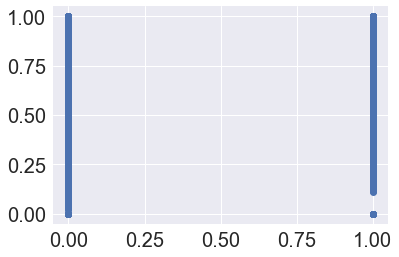

In [16]:
plt.plot(data['is_duplicate'], data['cosine'],'o')

## Jaccard Similarity

In [60]:
data['Jaccard'] = data.apply(lambda row: 0 if (len(row['question1'])+len(row['question2'])-row['Common']) == 0  else float(row['Common'])/((len(row['question1'])+len(row['question2'])-row['Common'])), axis=1)
data.ix[np.random.choice(data.index,10)]

,id,qid1,qid2,question1,question2,is_duplicate,Common,Average,Percentage,cosine,Jaccard
266155,266155,135335,383281,"[stop, comparing, others]","[stop, comparing, life, people, better]",1,2,4.0,40.000000,0.516398,0.333333
309933,309933,433982,433983,"[percentage, people, using, quora, ever, heard...","[food, additives, use, carrier, agent, dissolv...",0,0,8.0,0.000000,0.000000,0.000000
377494,377494,508797,296163,"[could, someone, provide, reading, materials, ...","[universe, expanding, first, time]",0,0,6.5,0.000000,0.000000,0.000000
91719,91719,153648,153649,"[best, pair, studio, monitors, $220]","[best, studio, monitors, $450, per, pair]",0,4,5.5,61.538462,0.730297,0.571429
111743,111743,130032,182957,"[best, get, started, freelancing, web, develop...","[start, freelancing, web, developer]",1,3,7.0,37.500000,0.668153,0.272727
381435,381435,12346,324941,"[good, anime, movies]","[best, animated, movie, you've, ever, watched]",0,0,4.5,0.000000,0.000000,0.000000
21006,21006,39584,39585,"[zagat, yelp, ratings, compare]","[doesn't, google, make, zagat, completely, free]",0,1,5.0,16.666667,0.204124,0.111111
162497,162497,252958,122168,"[best, hindi, songs, karaoke]","[best, hindi, songs]",0,3,3.5,66.666667,0.866025,0.750000
256646,256646,62262,278979,"[deal, stress]","[deal, stress]",1,2,2.0,66.666667,1.000000,1.000000
265015,265015,201193,381913,"[interesting, topics, new, users, follow]","[keep, track, interesting, content, topics, fo...",0,2,5.5,30.769231,0.365148,0.222222


In [30]:
data_test = pd.read_csv("/Users/sominwadhwa/Work/Kaggle_Data/Quora/test.csv")

In [64]:
data_test = data_test.dropna()
data_test['question1'] = data_test['question1'].apply(lambda x: x.rstrip('?'))
data_test['question2'] = data_test['question2'].apply(lambda x: x.rstrip('?'))
data_test['question1'] = data_test['question1'].str.lower().str.split()
data_test['question2'] = data_test['question2'].str.lower().str.split()
data_test['question1'] = data_test['question1'].apply(lambda x: [item for item in x if item not in stop])
data_test['question2'] = data_test['question2'].apply(lambda x: [item for item in x if item not in stop])


In [66]:
data_test['Common'] = data_test.apply(lambda row: len(list(set(row['question1']).intersection(row['question2']))), axis=1)
data_test['Average'] = data_test.apply(lambda row: 0.5*(len(row['question1'])+len(row['question2'])), axis=1)
data_test['Percentage'] = data_test.apply(lambda row: 1 if row['Average'] == 0 else row['Common']/(row['Average']), axis=1)

In [67]:
data_test['Jaccard'] = data_test.apply(lambda row: 0 if (len(row['question1'])+len(row['question2'])-row['Common']) == 0  else float(row['Common'])/((len(row['question1'])+len(row['question2'])-row['Common'])), axis=1)
df4 = pd.DataFrame({'test_id' : range(0,2345796)})
df4['is_duplicate']=pd.Series(data_test['Jaccard'])
df4.fillna(0, inplace = True)
df4.to_csv('base_submission.csv', index=False)

Jaccard doing very poorly on the LB. Trying something else. XGB...

In [31]:
tfidf = TfidfVectorizer(stop_words='english',ngram_range=(1, 1))

In [32]:
tfidf_txt = pd.Series(data['question1'].tolist() + data['question2'].tolist() + data_test['question1'].tolist() + data_test['question2'].tolist()).astype(str)
tfidf.fit_transform(tfidf_txt)

<5500172x121139 sparse matrix of type '<class 'numpy.float64'>'
	with 28389430 stored elements in Compressed Sparse Row format>

In [56]:
def diff_ratios(st1, st2):
    seq = difflib.SequenceMatcher()
    seq.set_seqs(str(st1).lower(), str(st2).lower())
    return seq.ratio()

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stop:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stop:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

def get_features(df_features):
    print('nouns...')
    df_features['question1_nouns'] = df_features.question1.map(lambda x: [w for w, t in nltk.pos_tag(nltk.word_tokenize(str(x).lower())) if t[:1] in ['N']])
    print ("---Q1 Nouns Complete")
    df_features['question2_nouns'] = df_features.question2.map(lambda x: [w for w, t in nltk.pos_tag(nltk.word_tokenize(str(x).lower())) if t[:1] in ['N']])
    print ("---Q2 Nouns Complete")
    df_features['z_noun_match'] = df_features.apply(lambda r: sum([1 for w in r.question1_nouns if w in r.question2_nouns]), axis=1)  #takes long
    print ("---Nouns Matching Complete")
    print('lengths...')
    df_features['z_len1'] = df_features.question1.map(lambda x: len(str(x)))
    print ("---Q1-Length Complete")
    df_features['z_len2'] = df_features.question2.map(lambda x: len(str(x)))
    print ("---Q2-Length Complete")
    df_features['z_word_len1'] = df_features.question1.map(lambda x: len(str(x).split()))
    print ("---Q1-Length-word Complete")
    df_features['z_word_len2'] = df_features.question2.map(lambda x: len(str(x).split()))
    print ("---Q2-Length-word Complete")
    print('difflib...')
    df_features['z_match_ratio'] = df_features.apply(lambda r: diff_ratios(r.question1, r.question2), axis=1)  #takes long
    print ("---Difflib match complete")
    print('word match...')
    df_features['z_word_match'] = df_features.apply(word_match_share, axis=1, raw=True)
    print ("---Word Match Complete")
    print('tfidf...')
    df_features['z_tfidf_sum1'] = df_features.question1.map(lambda x: np.sum(tfidf.transform([str(x)]).data))
    print ("---Q1-tfidf-sum Complete")
    df_features['z_tfidf_sum2'] = df_features.question2.map(lambda x: np.sum(tfidf.transform([str(x)]).data))
    print ("---Q2-tfidf-sum Complete")
    df_features['z_tfidf_mean1'] = df_features.question1.map(lambda x: np.mean(tfidf.transform([str(x)]).data))
    print ("Q1-tfidf-mean Complete")
    df_features['z_tfidf_mean2'] = df_features.question2.map(lambda x: np.mean(tfidf.transform([str(x)]).data))
    print ("Q2-tfidf-mean Complete")
    df_features['z_tfidf_len1'] = df_features.question1.map(lambda x: len(tfidf.transform([str(x)]).data))
    print ("Q1-tfidf-len Complete")
    df_features['z_tfidf_len2'] = df_features.question2.map(lambda x: len(tfidf.transform([str(x)]).data))
    print ("Q2-tfidf-len Complete")
    return df_features.fillna(0.0)

In [ ]:
data = get_features(data)

In [57]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [36]:
col = [c for c in data.columns if c[:1]=='z']

pos_train = data[data['is_duplicate'] == 1]
neg_train = data[data['is_duplicate'] == 0]
p = 0.175
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
train = pd.concat([pos_train, neg_train])

In [40]:
X, Xcv, Y, Ycv = train_test_split(train[col], train['is_duplicate'], test_size=0.1, random_state=0)

In [41]:
params = {}
params["objective"] = "binary:logistic"
params['eval_metric'] = 'logloss'
params["eta"] = 0.02
params["subsample"] = 0.7
params["min_child_weight"] = 1
params["colsample_bytree"] = 0.7
params["max_depth"] = 4
params["silent"] = 1
params["seed"] = 1632

d_train = xgb.DMatrix(X, label=Y)
d_valid = xgb.DMatrix(Xcv, label=Ycv)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=50, verbose_eval=100)
print(log_loss(train.is_duplicate, bst.predict(xgb.DMatrix(train[col]))))

[0]	train-logloss:0.683573	valid-logloss:0.683572
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.402692	valid-logloss:0.403008
[200]	train-logloss:0.374388	valid-logloss:0.374868
[300]	train-logloss:0.368062	valid-logloss:0.368721
[400]	train-logloss:0.364743	valid-logloss:0.365587
0.362041995203


In [61]:
data_test = get_features(data_test)

nouns...
---Q1 Nouns Complete
---Q2 Nouns Complete
---Nouns Matching Complete
lengths...
---Q1-Length Complete
---Q2-Length Complete
---Q1-Length-word Complete
---Q2-Length-word Complete
difflib...
---Difflib match complete
word match...
---Word Match Complete
tfidf...
---Q1-tfidf-sum Complete
---Q2-tfidf-sum Complete


//anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
//anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Q1-tfidf-mean Complete
Q2-tfidf-mean Complete
Q1-tfidf-len Complete
Q2-tfidf-len Complete


In [66]:
xgb_base = pd.DataFrame()
xgb_base['test_id'] = data_test['test_id']
xgb_base['is_duplicate'] = bst.predict(xgb.DMatrix(data_test[col]))

xgb_base.to_csv('submission_xgb_01.csv', index=False)